In [1]:
from gtts import gTTS
tts = gTTS('The Speech Transmission Index (STI) is a method of measuring speech intelligibility in noisy and reverberant environments.')
tts.save('sentence.mp3')

In [60]:
from pya import Asig, Ugen

sen = Asig("sentence.mp3")
sen

Asig('sentence.mp3'): 1 x 236160 @ 24000Hz = 9.840s cn=['0']

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pya import Asig, Ugen
ir = Asig("ir1.wav").mono().norm()
fs = ir.sr
ir = ir.sig

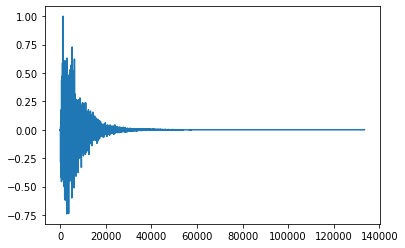

In [2]:
plt.plot(ir)

In [18]:
from scipy.signal import butter, lfilter, firwin
from warnings import catch_warnings,simplefilter

def octave_filters(x, fs, N=6,
                  f0 =[125, 250, 500, 1000, 2000, 4000, 8000],
                  hammingTime=16.6):
    """Octave band filters for STI measurement. 
    
    Parameters
    ----------
    fs : int
        Sampling frequency
    N : int
        Filter order
    f0 : list
        Center frequency of each octave
    """
   # calculate the nyquist frequency
    nyquist = fs * 0.5
    # length of Hamming window for FIR low-pass at 25 Hz
    hammingLength = (hammingTime / 1000.0) * fs
    # process each octave band
    for f in f0:
        # filter the output at the octave band f
        f1 = f / np.sqrt(2)
        f2 = f * np.sqrt(2)

        if f < max(f0):
            with catch_warnings():      # suppress the spurious warnings given
                simplefilter('ignore')  # under certain conditions
                b1,a1 = butter(N, f1 / nyquist, btype='high')
                b2,a2 = butter(N, f2 / nyquist, btype='low')
            
            filtOut = lfilter(b1, a1, x)   # high-pass raw audio at f1
            filtOut = lfilter(b2, a2, filtOut) # low-pass after high-pass at f1
        else:
            with catch_warnings():
                simplefilter('ignore')
                b1,a1 = butter(N, f / nyquist, btype='high')
            filtOut = lfilter(b1, a1, x)

#         filtOut = np.array(filtOut) ** 2
#         b = firwin(int(hammingLength), 25.0, nyq=nyquist)
#         filtOut = lfilter(b, 1, filtOut)
#         filtOut = filtOut * -1.0

        # stack-up octave band filtered audio
        try:
            octaveBandAudio = np.vstack((octaveBandAudio, filtOut))
        except:
            octaveBandAudio = filtOut

    return octaveBandAudio
    

In [77]:
from scipy.interpolate import interp1d

def pow2db(x):
    return 10 * np.log10(x)

def get_mtf(ir):
    return np.abs(np.fft.rfft(ir ** 2) / np.sum(ir ** 2))

def sti(ir, fs):
    
    # 1. filter ir through octave bands
    # 2. get MTF through 
    Nfc = 7  # 7 octaves from 125 - 8000Hz
    
    
    ir_filtered = octave_filters(ir, fs)
    # MTF function. 
    mtf = get_mtf(ir_filtered)
    
    modulation_freqs = [0.63, 0.80, 1.00, 1.25, 1.60, 2.00, 2.50, 3.15, 4.00, 5.00, 6.30, 8.00, 10.00, 12.50]
    freqs = np.linspace(0, fs // 2, mtf.shape[1])
#     freqs[-1] = 0 # No nyquist frequency


    m = np.zeros((len(modulation_freqs), Nfc))
    for i in range(Nfc):
        # Old x is freqs, y is mtf[i, :], newx = modulation_freqs
#         m(i,:) = interp1(freqs,MTF_octband(1:end/2,i),modulation_freqs);
        interp = interp1d(freqs, mtf[i, :])
        m[:, i] = interp(modulation_freqs)
    
    
    # Convert each of the 98m values into an apparent SNR in dB
    SNR_apparent = pow2db(m / (1 - m))
    
    # Limit the range
    SNR_apparent = np.clip(SNR_apparent, -15, 15)

    
    # Compute the mean (S/N) for each octave band
    SNR_avg = np.mean(SNR_apparent, axis=0)
    
    # weight the octave mean (S/N) vals
    W = [0.13, 0.14, 0.11, 0.12, 0.19, 0.17, 0.14]
    
    weighted_m = m * W

    SNR_avg_weighted = np.sum(np.dot(weighted_m, SNR_avg))
    SNR_avg_weighted_approx = np.sum(np.dot(weighted_m / np.sum(weighted_m), SNR_avg))
    
    # Convert the overall mean to an STI val
    sti_val = (SNR_avg_weighted + 15) / 30
    sti_val_approx = (SNR_avg_weighted_approx + 15) / 30
    
    return mtf, sti_val, sti_val_approx, m

noise = Ugen().noise(amp=0.01, sr=fs, n_rows=len(ir))
sig = ir + noise.sig

mtf, sti_val, sti_approx, m = sti(ir, fs)



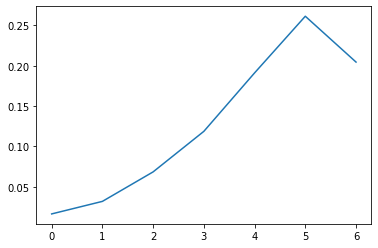

In [78]:
plt.plot(ir_filtered[0, :])

In [79]:
sti_val

0.13756920261055522

In [68]:
m = m + 0.5

In [70]:
pow2db(m / (1 - m))

array([[0.28005301, 0.55620434, 1.19476078, 2.10545547, 3.49108107,
        5.03901962, 3.76663878],
       [0.26727628, 0.52815159, 1.14444079, 2.01626085, 3.34435631,
        4.83188639, 3.64521902],
       [0.25154992, 0.49347097, 1.08274056, 1.90658418, 3.164565  ,
        4.57988729, 3.49398239],
       [0.2303964 , 0.44723558, 1.00360593, 1.76482957, 2.92644837,
        4.23698876, 3.26411645],
       [0.20118154, 0.38504237, 0.89832498, 1.57810427, 2.60521242,
        3.77299265, 2.92805916],
       [0.16923985, 0.32146311, 0.79156919, 1.38776166, 2.2744162 ,
        3.2882514 , 2.55940663],
       [0.13225207, 0.25622543, 0.68182871, 1.18032159, 1.93352544,
        2.77782787, 2.14496118],
       [0.0904347 , 0.19566756, 0.55700199, 0.94191328, 1.60140015,
        2.26805992, 1.74145001],
       [0.05191017, 0.16269233, 0.42042449, 0.68600055, 1.31630857,
        1.82891749, 1.40642733],
       [0.03162584, 0.1351444 , 0.28061725, 0.45507888, 1.07635163,
        1.46931824, 1.1

In [34]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])